In [172]:
!pip install -U scikit-learn > None

In [173]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer, make_classification, load_iris
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression,Ridge,ElasticNet, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, mean_squared_error, classification_report, accuracy_score,  confusion_matrix, precision_score, recall_score, f1_score, fbeta_score, precision_recall_curve
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

Чтение файла

In [174]:
data=pd.read_csv('https://raw.githubusercontent.com/Vladcder/HomeWork/refs/heads/main/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Выбор подходящих параметров из датасета

In [175]:
cutted_data=data.drop(columns=['PassengerId','Name','Ticket','Cabin'])
cutted_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Замена категориальных признаков

In [176]:
dummy_data = pd.get_dummies(cutted_data, columns =['Sex','Pclass', 'Embarked'], drop_first=True, dtype=np.uint8).dropna()
dummy_data.head()

,Survived,Age,SibSp,Parch,Fare,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,1,0,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1
4,0,35.0,0,0,8.0500,1,0,1,0,1


In [177]:
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    714 non-null    int64  
 1   Age         714 non-null    float64
 2   SibSp       714 non-null    int64  
 3   Parch       714 non-null    int64  
 4   Fare        714 non-null    float64
 5   Sex_male    714 non-null    uint8  
 6   Pclass_2    714 non-null    uint8  
 7   Pclass_3    714 non-null    uint8  
 8   Embarked_Q  714 non-null    uint8  
 9   Embarked_S  714 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 37.0 KB


Проверка мультиколлинеарности

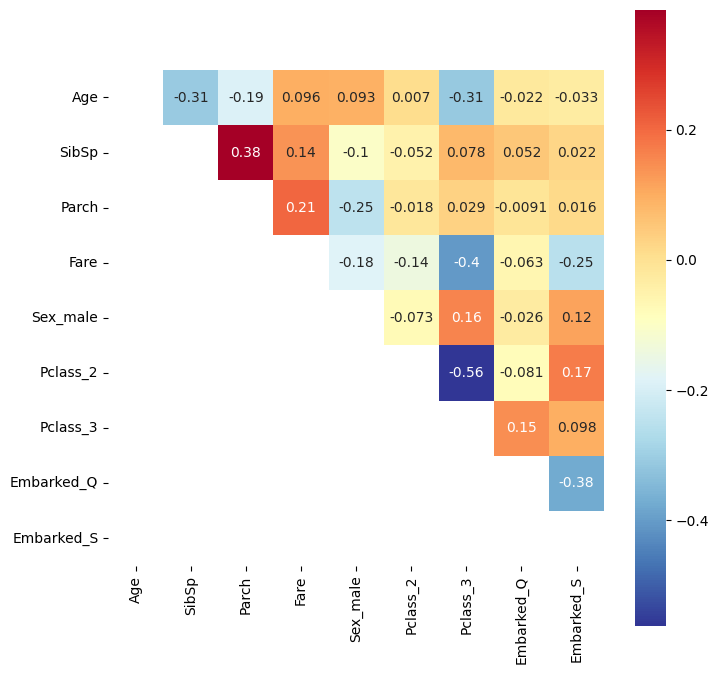

In [178]:

corrs = dummy_data.drop(columns='Survived').corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))
plt.figure(figsize=(8, 8))
sns.heatmap(upper_tri, cmap="RdYlBu_r", square=True, annot=True);

Разбиение датасета

In [179]:
X_train, X_test, y_train, y_test=train_test_split(
    dummy_data.drop(columns='Survived'),
    dummy_data['Survived'],
    random_state=2024,
    test_size=0.3
)

In [180]:
y_train.value_counts()

,count
Survived,
0,291
1,208


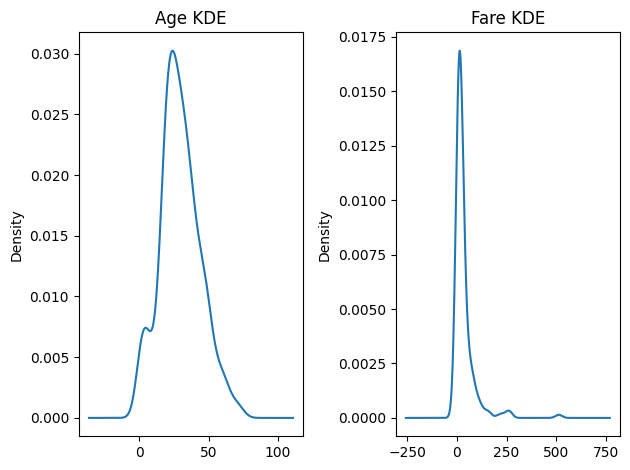

In [181]:
plt.subplot(1, 2, 1)
X_train['Age'].plot.kde(title='Age KDE');
plt.subplot(1, 2, 2)
X_train['Fare'].plot.kde(title='Fare KDE');
plt.tight_layout()

Нормировка данных

In [182]:
scaler=StandardScaler()
X_train_scaled=pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled=pd.DataFrame(
    scaler.fit_transform(X_test),
    columns=X_test.columns
)

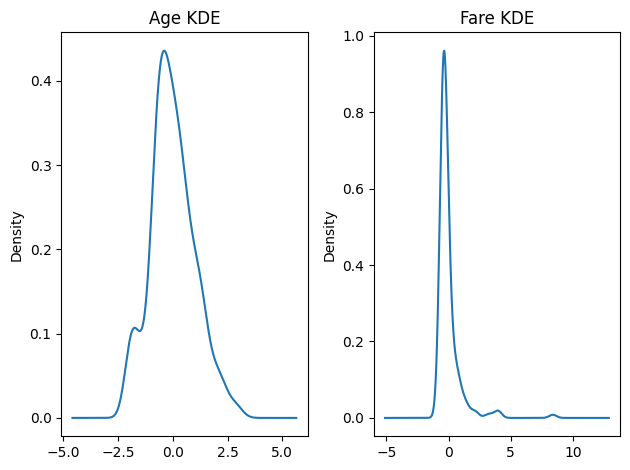

In [183]:
plt.subplot(1, 2, 1)
X_train_scaled['Age'].plot.kde(title='Age KDE');
plt.subplot(1, 2, 2)
X_train_scaled['Fare'].plot.kde(title='Fare KDE');
plt.tight_layout()

Константный классификатор

In [184]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train);
y_pred_dummy = dummy_clf.predict(X_test)
accuracy_score(y_test,y_pred_dummy)

0.6186046511627907

Выбор метрик

Метрика accuracy может быть использована в качестве первого приближения при оценки модели. Для более серьезных оценок её применение ограничено из-за возможного наличия дисбаланса классов. Поскольку данная задача относиться к задаче бинарной классификации (0 - пассажир погиб, 1 - пассажир выжил) более подходящеми метриками являются precision, recall или f-score



Модель классификации

In [185]:
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train_scaled, y_train);
y_pred_log_reg = log_reg.predict(X_test_scaled)
accuracy_score(y_test,y_pred_log_reg)

0.8046511627906977

Измерения качества модели

In [186]:
print(f'Precision for Dummy Classificator: {precision_score(y_test, y_pred_dummy, zero_division=0)}')
print(f'Precision for Logistic regression: {precision_score(y_test, y_pred_log_reg, zero_division=0)}')
print(f'Recall for Dummy Classificator: {recall_score(y_test, y_pred_dummy)}')
print(f'Recall for Logistic regression: {recall_score(y_test, y_pred_log_reg)}')
print(f'F1-score for Dummy Classificator: {f1_score(y_test, y_pred_dummy)}')
print(f'F1-score for Logistic regression: {f1_score(y_test, y_pred_log_reg)}')


Precision for Dummy Classificator: 0.0
Precision for Logistic regression: 0.717391304347826
Recall for Dummy Classificator: 0.0
Recall for Logistic regression: 0.8048780487804879
F1-score for Dummy Classificator: 0.0
F1-score for Logistic regression: 0.7586206896551724
